In [1]:
import numpy as np;
import matplotlib.pyplot as plt;

import numpy as np;
import matplotlib.pyplot as plt;
import tensorflow as tf;
import keras
from keras import layers;
from scipy import linalg;
from IPython.display import clear_output

Using TensorFlow backend.


In [2]:
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();
        
plot = PlotLearning()

In [3]:
checkpoint = keras.callbacks.ModelCheckpoint('model-{epoch:03d}.h5',
                             verbose=1,
                             monitor='val_loss',
                             save_best_only=True,
                             mode='auto')  

In [4]:
def generate_signal(N):
    # центр, ширина и высота первого треугольника
    width1 = np.random.uniform(0.1, 0.2)
    center1 = np.random.uniform(width1, 0.5 - width1)
    height1 = np.random.uniform(-2, 2)
    # центра, ширина и высота второго треугольника
    width2 = np.random.uniform(0.1, 0.2)
    center2 = np.random.uniform(0.5 + width2, 0.5 - width2)
    height2 = np.random.uniform(-2, 2)
    signal = np.zeros(N)
    dt = 1.0/(N - 1)
    for i in range(N):
        t = i*dt
        if t > center2 + width2:
            signal[i] = 0.0
        elif t > center2:
            signal[i] = height2*(center2 + width2 - t)/width2
        elif t > center2 - width2:
            signal[i] = height2*(t - center2 + width2)/width2
        elif t > center1 + width1:
            signal[i] = 0.0
        elif t > center1:
            signal[i] = height1*(center1 + width1 - t)/width1
        elif t > center1 - width1:
            signal[i] = height1*(t - center1 + width1)/width1
        elif t > 0:
            signal[i] = 0.0
            
    return signal

In [5]:
def test_signal(x):
    if x > 0.7:
        return 0.0
    elif x > 0.6:
        return (0.7 - x)/0.1
    elif x > 0.5:
        return (x - 0.5)/0.1  
    elif x > 0.4:
        return (0.5 - x)/0.1  
    elif x > 0.3:
        return (x - 0.3)/0.1
    else:
        return 0.0

In [6]:
def generate_smoothing_matrix(size_in, size_out, half_width):
    m = np.zeros([size_out, size_in])
    width = 2.0*half_width
    value = 1.0 / width
    # value = 1.0
    for i in range(size_out):
        m[i, i] = value
        for j in range(0, half_width):
            index_right = i + j + 1
            index_left = i - j - 1
            if index_right < size_out:
                m[i, index_right] = value
            if index_left >= 0:
                m[i, index_left] = value
    return m

In [7]:
def generate_correlated_vector(sqrt_covariance_operator):
    return sqrt_covariance_operator@np.random.normal(0, 1, np.size(sqrt_covariance_operator, 0))

In [8]:
N = 101
halfWidth = 10
A = generate_smoothing_matrix(N, N, halfWidth)
t = np.arange(0, 1.0 + 1.e-10, 1.0/(N - 1))
f0 = np.zeros(N)

for i in range(N):
    f0[i] = test_signal(t[i])

In [9]:
sqrt_F = 0.1*np.eye(N)
F = sqrt_F.T@sqrt_F

sqrt_Sigma = 0.1*np.eye(N)
Sigma = sqrt_Sigma.T@sqrt_Sigma

f = f0 + generate_correlated_vector(sqrt_F)
nu = generate_correlated_vector(sqrt_Sigma)
smoothed_f = A@f
ksi = A@f + nu

Sigma_inversed = np.linalg.inv(Sigma)
T = A.T@Sigma_inversed@A
v = A.T@Sigma_inversed@ksi
T_aprior = np.linalg.inv(F)
v_aprior = T@f0

lin_est_f = f0 + np.linalg.inv(T + T_aprior)@(v - v_aprior)

In [10]:
n_train = 10000

f_train = np.zeros([n_train, N])
ksi_train = np.zeros([n_train, N])

for i in range(n_train):
    signal = generate_signal(N)
    temp_f = signal + generate_correlated_vector(sqrt_F)
    f_train[i, :] = temp_f
    ksi_train[i, :] = A@temp_f + generate_correlated_vector(sqrt_Sigma)


print(f_train.shape)


(10000, 101)


In [11]:
model = keras.Sequential([
#     # best!
#     keras.layers.Dense(10*N, activation=keras.activations.tanh), #sigmoid
#     keras.layers.Reshape((10*N, 1), input_shape=(10*N,)),
#     keras.layers.convolutional.Conv1D(20, 9, activation='tanh',input_shape=(10*N, 1)),
#     keras.layers.normalization.BatchNormalization(),
#     keras.layers.Reshape((20*(10*N-8),), input_shape=(20*(10*N-8),1)),
#     keras.layers.Dense(N) #sigmoid
    
    keras.layers.Dense(4*N, activation=keras.activations.tanh),
    keras.layers.Reshape((4*N, 1), input_shape=(4*N,)),
    keras.layers.convolutional.Conv1D(100, 15, activation='tanh',input_shape=(4*N, 1)),
    keras.layers.normalization.BatchNormalization(),
    keras.layers.Reshape((100*(4*N-14),), input_shape=(50*(4*N-14),1)),
    keras.layers.Dense(N, activation=keras.activations.sigmoid) #sigmoid
    
    #rather good!
#     keras.layers.Reshape((N, 1), input_shape=(N,)),
#     keras.layers.convolutional.Conv1D(128, 15, activation='tanh', padding='causal'),
#     keras.layers.convolutional.Conv1D(64, 5, activation='relu', padding='causal'),
#     keras.layers.normalization.BatchNormalization(),
#     keras.layers.convolutional.Conv1D(1, 15, padding='causal'),
#     keras.layers.Reshape((N,), input_shape=(N, 1)),
#     keras.layers.Dense(N),


    
#     keras.layers.Reshape((N, 1), input_shape=(N,)),
#     keras.layers.convolutional.Conv1D(150, 11, activation='tanh',input_shape=(N, 1)),
#     keras.layers.Reshape((1, 150*(N-10)), input_shape=(N-10, 150)),
#     keras.layers.Dense(N+10, activation='relu'),
#     keras.layers.normalization.BatchNormalization(),
#     keras.layers.Permute((2, 1)),
#     keras.layers.convolutional.Conv1D(1, 11, activation='relu'),
#     keras.layers.Reshape((N,), input_shape=(N, 1)),
])
# print(model.summary())

In [12]:
print(f_train.shape)
f_train.shape

(10000, 101)


(10000, 101)

In [13]:
X = ksi_train
y = f_train
print(X.shape)
print(y.shape)
model.compile(loss="mse", optimizer="adam")
model.fit(X, y,
          batch_size = 32,
          epochs=100,
          validation_split=0.1,
#           shuffle = False
          callbacks=[checkpoint], #plot
         )



(10000, 101)
(10000, 101)
Train on 9000 samples, validate on 1000 samples
Epoch 1/100
9000/9000 [==============================] - 25s 3ms/step - loss: 0.2091 - val_loss: 0.2489

Epoch 00001: val_loss improved from inf to 0.24890, saving model to model-001.h5
Epoch 2/100
9000/9000 [==============================] - 27s 3ms/step - loss: 0.1384 - val_loss: 0.2452

Epoch 00002: val_loss improved from 0.24890 to 0.24519, saving model to model-002.h5
Epoch 3/100
9000/9000 [==============================] - 25s 3ms/step - loss: 0.1380 - val_loss: 0.2487

Epoch 00003: val_loss did not improve from 0.24519
Epoch 4/100
9000/9000 [==============================] - 24s 3ms/step - loss: 0.1379 - val_loss: 0.2489

Epoch 00004: val_loss did not improve from 0.24519
Epoch 5/100
9000/9000 [==============================] - 25s 3ms/step - loss: 0.1378 - val_loss: 0.2489

Epoch 00005: val_loss did not improve from 0.24519
Epoch 6/100
9000/9000 [==============================] - 25s 3ms/step - loss: 0.13

Epoch 49/100
9000/9000 [==============================] - 24s 3ms/step - loss: 0.1364 - val_loss: 0.1319

Epoch 00049: val_loss improved from 0.13199 to 0.13195, saving model to model-049.h5
Epoch 50/100
9000/9000 [==============================] - 24s 3ms/step - loss: 0.1364 - val_loss: 0.1319

Epoch 00050: val_loss improved from 0.13195 to 0.13185, saving model to model-050.h5
Epoch 51/100
9000/9000 [==============================] - 24s 3ms/step - loss: 0.1364 - val_loss: 0.1320

Epoch 00051: val_loss did not improve from 0.13185
Epoch 52/100
9000/9000 [==============================] - 24s 3ms/step - loss: 0.1364 - val_loss: 0.1320

Epoch 00052: val_loss did not improve from 0.13185
Epoch 53/100
9000/9000 [==============================] - 23s 3ms/step - loss: 0.1364 - val_loss: 0.1320

Epoch 00053: val_loss did not improve from 0.13185
Epoch 54/100
9000/9000 [==============================] - 23s 3ms/step - loss: 0.1363 - val_loss: 0.1321

Epoch 00054: val_loss did not improve fro

9000/9000 [==============================] - 24s 3ms/step - loss: 0.1359 - val_loss: 0.1316

Epoch 00099: val_loss improved from 0.13161 to 0.13159, saving model to model-099.h5
Epoch 100/100
9000/9000 [==============================] - 24s 3ms/step - loss: 0.1359 - val_loss: 0.1318

Epoch 00100: val_loss did not improve from 0.13159


In [14]:
X_test = ksi.reshape([1, N])
f_ANN = model.predict_on_batch(X_test).reshape(N,)
f_ANN.shape
mse = np.sqrt(((f_ANN - f)**2).mean())
print(mse)
mse_r = np.sqrt(((lin_est_f - f)**2).mean())
print(mse_r)
mse_naive = np.sqrt(((f0 - f)**2).mean())
print(mse_naive)

0.13924462602306475
0.09873519190143204
0.09873756291807965


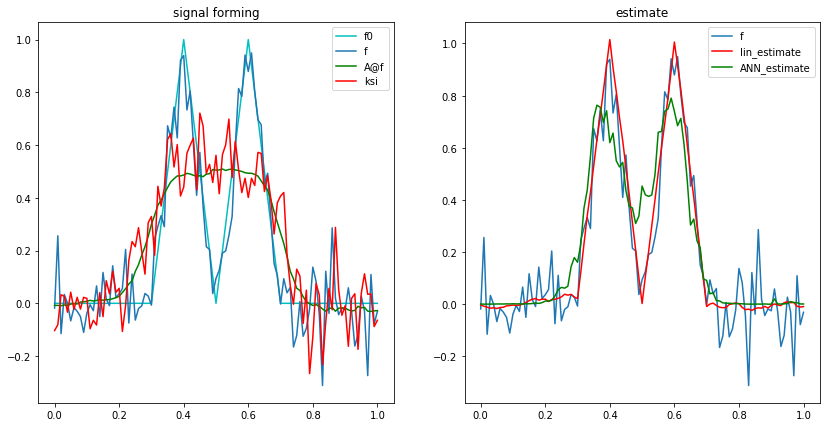

In [17]:
plt.subplot(1, 2, 1)
plt.plot(t, f0, 'c')
plt.plot(t, f)
plt.plot(t, smoothed_f, 'g')
plt.plot(t, ksi, 'r')
plt.title('signal forming')
plt.legend(['f0', 'f', 'A@f', 'ksi'])
plt.subplot(1, 2, 2)
plt.plot(t, f)
plt.plot(t, lin_est_f.transpose(), 'r')
plt.plot(t, f_ANN.reshape(101,), 'g')
plt.title('estimate')
plt.legend(['f', 'lin_estimate', 'ANN_estimate'])
plt.rcParams["figure.figsize"] = (14,7)
plt.show()

In [16]:
model.save('my_model-morning.h5')  # creates a HDF5 file 'my_model.h5'